# Exploration and visualization of the CRC data

The purpose of this notebook is to increase my understanding of the data used for modeling.
This includes the data collected by the DepMap consortium and cell line information from the CCLE.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import dask
import dask.dataframe as dd
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from dask.distributed import Client, progress
from scipy import stats
from sklearn.decomposition import PCA
from theano import tensor as tt

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import biology as biohelp
from src.data_processing import common as dphelp
from src.data_processing import vectors as vhelp
from src.globals import PYMC3
from src.io import cache_io, data_io
from src.loggers import logger
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

sns.set_theme(style="whitegrid")
gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 809
np.random.seed(RANDOM_SEED)

## Setup

Because of the size of the data, I relied heavily on Dask for running data frame computation and manipulations.

In [5]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client

<Client: 'tcp://127.0.0.1:51265' processes=2 threads=4, memory=1.86 GiB>

In [6]:
data_path = data_io.data_path(data_io.DataFile.crc_data)
if data_path.exists():
    print(f"data file: '{data_path.as_posix()}'")
else:
    raise FileNotFoundError(data_path)

data file: '/Users/admin/Lab_Projects/speclet/modeling_data/depmap_modeling_dataframe_crc.csv'


In [7]:
data_types: dict[str, str] = {"age": "float64"}
for a in [
    "p_dna_batch",
    "replicate_id",
]:
    data_types[a] = "category"

crc_data = dd.read_csv(data_path, dtype=data_types)
crc_data.head(5)

sgrna                  replicate_id       lfc  \
0   AAACCTGCGGCGGTCGCCA                  LS513_c903R1  0.563383   
1  AAAGCCCAGGAGTATGGGAG  LS513-311Cas9_RepA_p6_batch2  0.594321   
2  AAATCAGAGAAACCTGAACG  LS513-311Cas9_RepA_p6_batch2 -0.363633   
3   AACAGCACACCGGCCCCGT                  LS513_c903R1 -0.512694   
4   AACCTCCGGACTCCTCAGC                  LS513_c903R1 -0.075108   

         p_dna_batch  genome_alignment hugo_symbol  screen  \
0  ERS717283.plasmid   chr8_66505451_-         VXN  sanger   
1                  2  chr2_130522105_-       CFC1B   broad   
2                  2  chr11_89916950_-    TRIM49D1   broad   
3  ERS717283.plasmid  chrX_156009834_-        IL9R  sanger   
4  ERS717283.plasmid   chr7_39609658_-        YAE1  sanger   

   multiple_hits_on_gene sgrna_target_chr  sgrna_target_pos  ...  \
0                   True                8          66505451  ...   
1                   True                2         130522105  ...   
2                   True               11          89916950  ...   
3                   True                X         156009834  ...   
4                   True                7          39609658  ...   

  num_mutations  any_deleterious  any_tcga_hotspot  any_cosmic_hotspot  \
0             0              NaN               NaN                 NaN   
1             0              NaN               NaN                 NaN   
2             0              NaN               NaN                 NaN   
3             0              NaN               NaN                 NaN   
4             0              NaN               NaN                 NaN   

   is_mutated  copy_number     lineage  primary_or_metastasis is_male   age  
0       False     0.956651  colorectal                primary    True  63.0  
1       False     0.953860  colorectal                primary    True  63.0  
2       False     0.960466  colorectal                primary    True  63.0  
3       False     0.478776  colorectal                primary    True  63.0  
4       False     1.437966  colorectal                primary    True  63.0  

[5 rows x 22 columns]

In [8]:
crc_data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'p_dna_batch', 'genome_alignment',
       'hugo_symbol', 'screen', 'multiple_hits_on_gene', 'sgrna_target_chr',
       'sgrna_target_pos', 'depmap_id', 'rna_expr', 'num_mutations',
       'any_deleterious', 'any_tcga_hotspot', 'any_cosmic_hotspot',
       'is_mutated', 'copy_number', 'lineage', 'primary_or_metastasis',
       'is_male', 'age'],
      dtype='object')

## Analysis

### Overview

Below is a print-out of the number of unique values in some of the more important columns.

In [9]:
for col, lbl in {
    "sgrna": "sgRNA",
    "hugo_symbol": "genes",
    "depmap_id": "cell lines",
    "lineage": "lineages",
    "screen": "data sources",
}.items():
    count = len(crc_data[col].unique())
    print(f"num {lbl}: {count:,}")

num sgRNA: 157,808
num genes: 18,182
num cell lines: 54
num lineages: 1
num data sources: 2


The two data sources are the DepMap data from the Broad and the Project SCORE data from the Sanger.
The first analysis I did was to compare the data from the two institutes that were collected on the same cell lines.

In [10]:
crc_data[["screen", "depmap_id"]].drop_duplicates().groupby("screen").count().compute()

depmap_id
screen           
broad          39
sanger         31

### Comparing cell lines included in both screens

There were 16 cell lines that were included in both screens.

In [11]:
celllines_in_both_screens = (
    crc_data[["screen", "depmap_id"]]
    .drop_duplicates()
    .groupby("depmap_id")
    .count()
    .compute()
    .query("screen > 1")
    .reset_index(drop=False)["depmap_id"]
    .tolist()
)

print(f"number of cell lines in both screens: {len(celllines_in_both_screens)}")

number of cell lines in both screens: 16


In [12]:
double_screen_data = crc_data[
    crc_data.depmap_id.isin(celllines_in_both_screens)
].compute()
double_screen_data.shape

(2524928, 22)

The plot below shows the distribution of log-fold change (LFC) values for each cell line included in both screens.
Already we can see that there may be some large discrepencies.

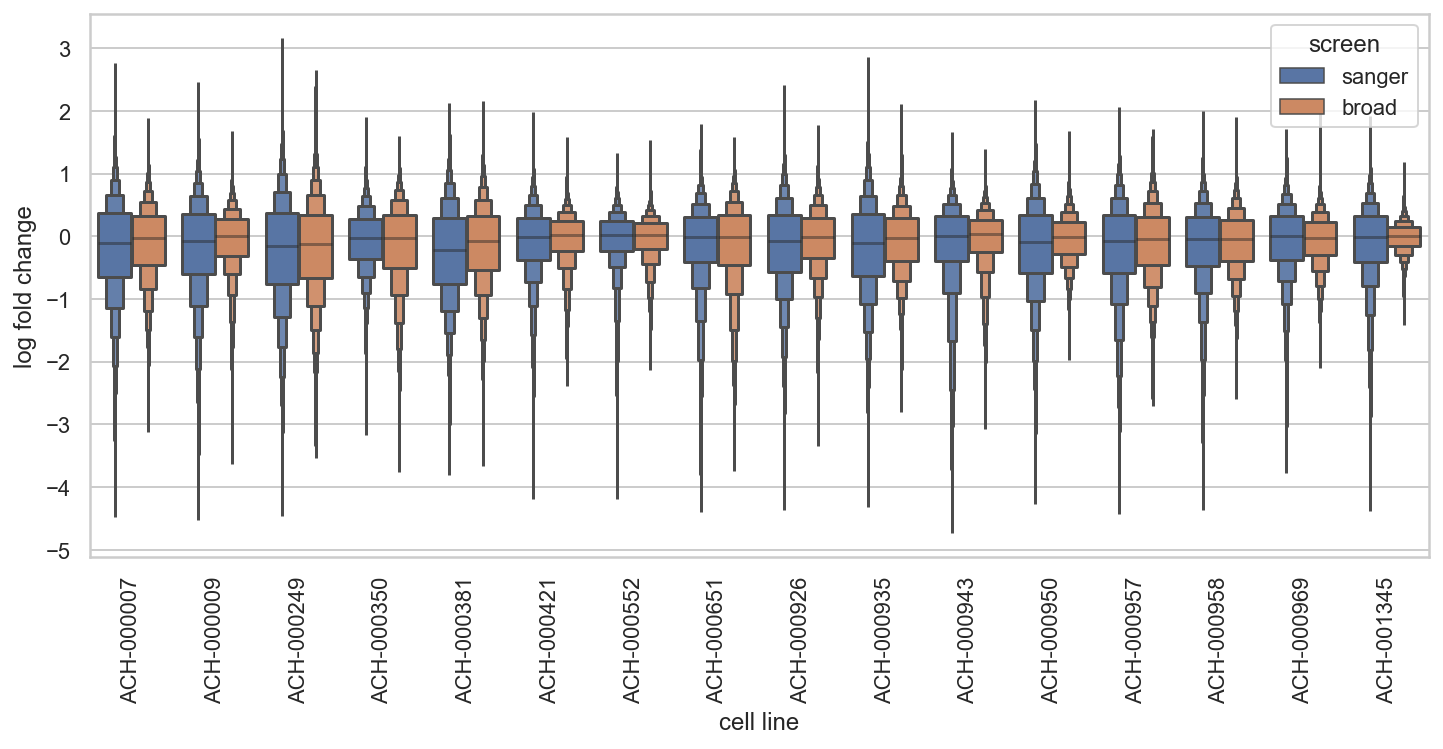

In [13]:
plt.figure(figsize=(12, 5))
ax = sns.boxenplot(
    data=double_screen_data,
    x="depmap_id",
    y="lfc",
    hue="screen",
    showfliers=False,
)
plt.xticks(rotation=90)
ax.set_xlabel("cell line")
ax.set_ylabel("log fold change")
plt.show()

I was curious about the correlation between the LFC of the genes in each cell line.
I calculated the correlation between the mean LFC for each gene of each cell line between the two screens.

In [14]:
double_screen_avg_lfc = (
    double_screen_data.groupby(["hugo_symbol", "depmap_id", "screen"])["lfc"]
    .mean()
    .reset_index(drop=False)
)

double_screen_gene_corr = double_screen_avg_lfc.pivot_wider(
    index=["hugo_symbol", "depmap_id"], names_from="screen", values_from="lfc"
)
double_screen_gene_corr = (
    double_screen_gene_corr.groupby("hugo_symbol")["broad"]
    .corr(double_screen_gene_corr["sanger"])
    .reset_index(drop=False)
    .rename(columns={"broad": "correlation"})
)

double_screen_gene_corr.head()

hugo_symbol  correlation
0        A1BG     0.114426
1        A1CF    -0.084924
2         A2M     0.076944
3       A2ML1    -0.252467
4     A3GALT2    -0.138956

These correlations are plotted against the mean LFC of the gene in the Broad (top) and Sanger (bottom).
There are a *very* large distribution of correlation values, including strong negative correlations.
Interestingly, there seems to be an association between the correlation values and the LFC values: for more negative LFC genes, the correlations tend to be smaller.

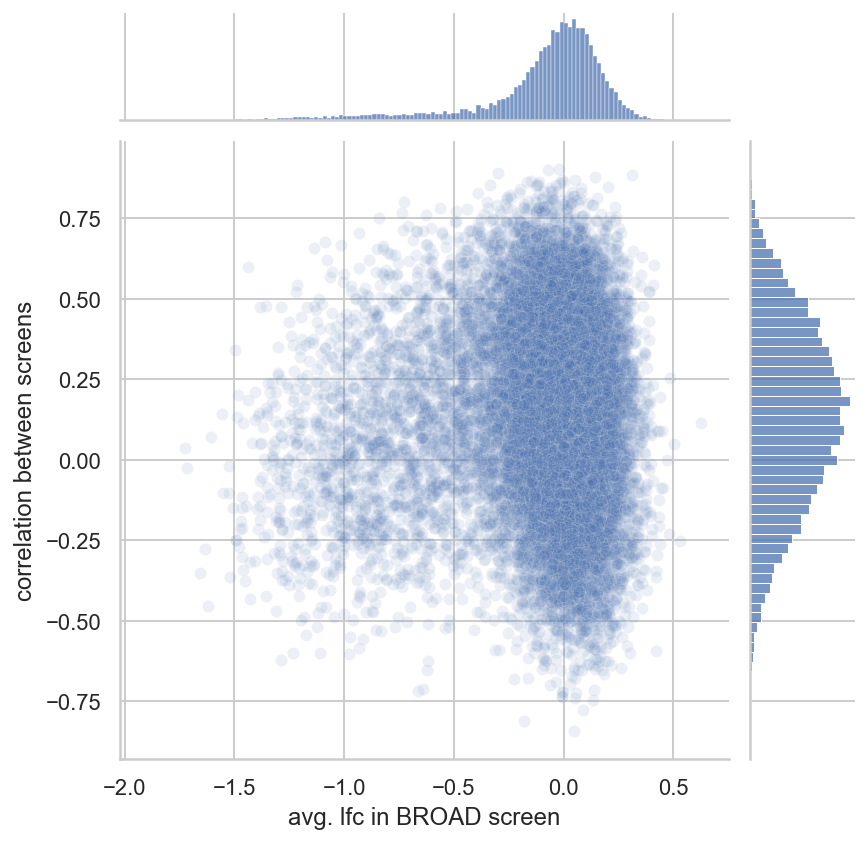

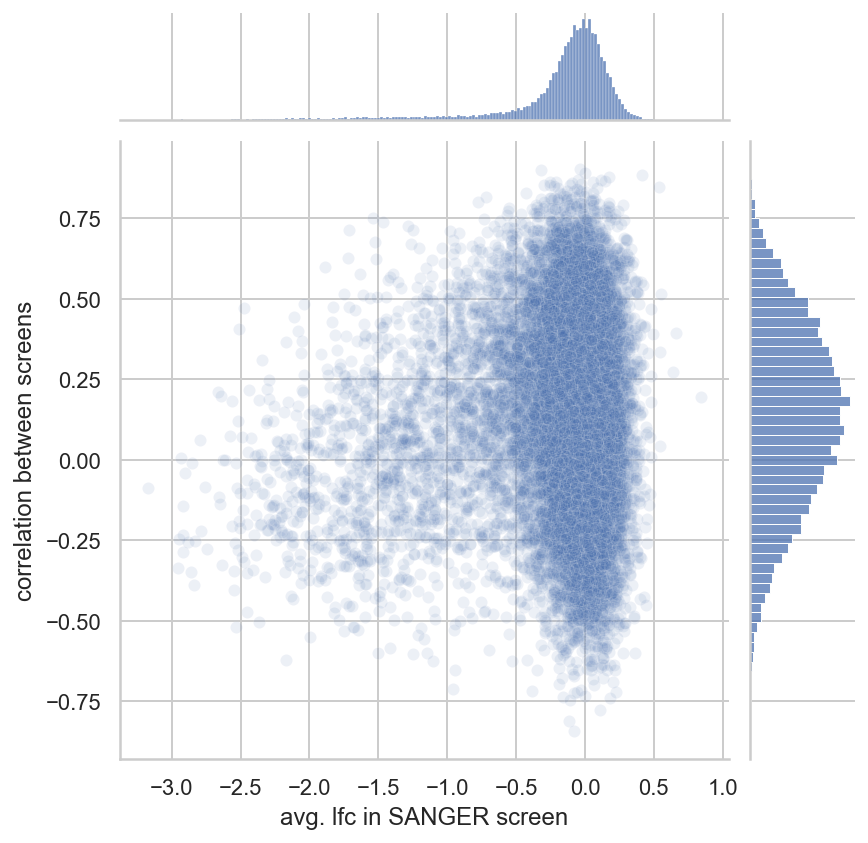

In [15]:
screen_averages = (
    double_screen_avg_lfc.groupby(["hugo_symbol", "screen"])["lfc"]
    .mean()
    .reset_index(drop=False)
    .pivot_wider(index=["hugo_symbol"], names_from="screen", values_from="lfc")
)

screen_gene_corr_avgs = double_screen_gene_corr.merge(screen_averages, on="hugo_symbol")

for screen in ("broad", "sanger"):
    jg = sns.jointplot(data=screen_gene_corr_avgs, x=screen, y="correlation", alpha=0.1)
    jg.ax_joint.set_xlabel(f"avg. lfc in {screen.upper()} screen")
    jg.ax_joint.set_ylabel(f"correlation between screens")
    plt.show()

**Moving forward, I only used the Broad data to avoid these very strong datasource biases.**

### Correlations of LFC and other factors

The next section of this analysis focused on looking at associations between LFC values and other data.

In [16]:
crc_data_avgs = (
    crc_data[crc_data.screen == "broad"][
        ["depmap_id", "hugo_symbol", "lfc", "rna_expr", "copy_number"]
    ]
    .groupby(["depmap_id", "hugo_symbol"])
    .mean()
    .compute()
    .reset_index(drop=False)
)

#### RNA expression

First, I plotted the LFC values for genes binned by their RNA expression.
It is very clear that more negative LFC values tend to be found for more highly-expressed genes.
This is not suprising and indicates that RNA expression can be an important covariate in the model.

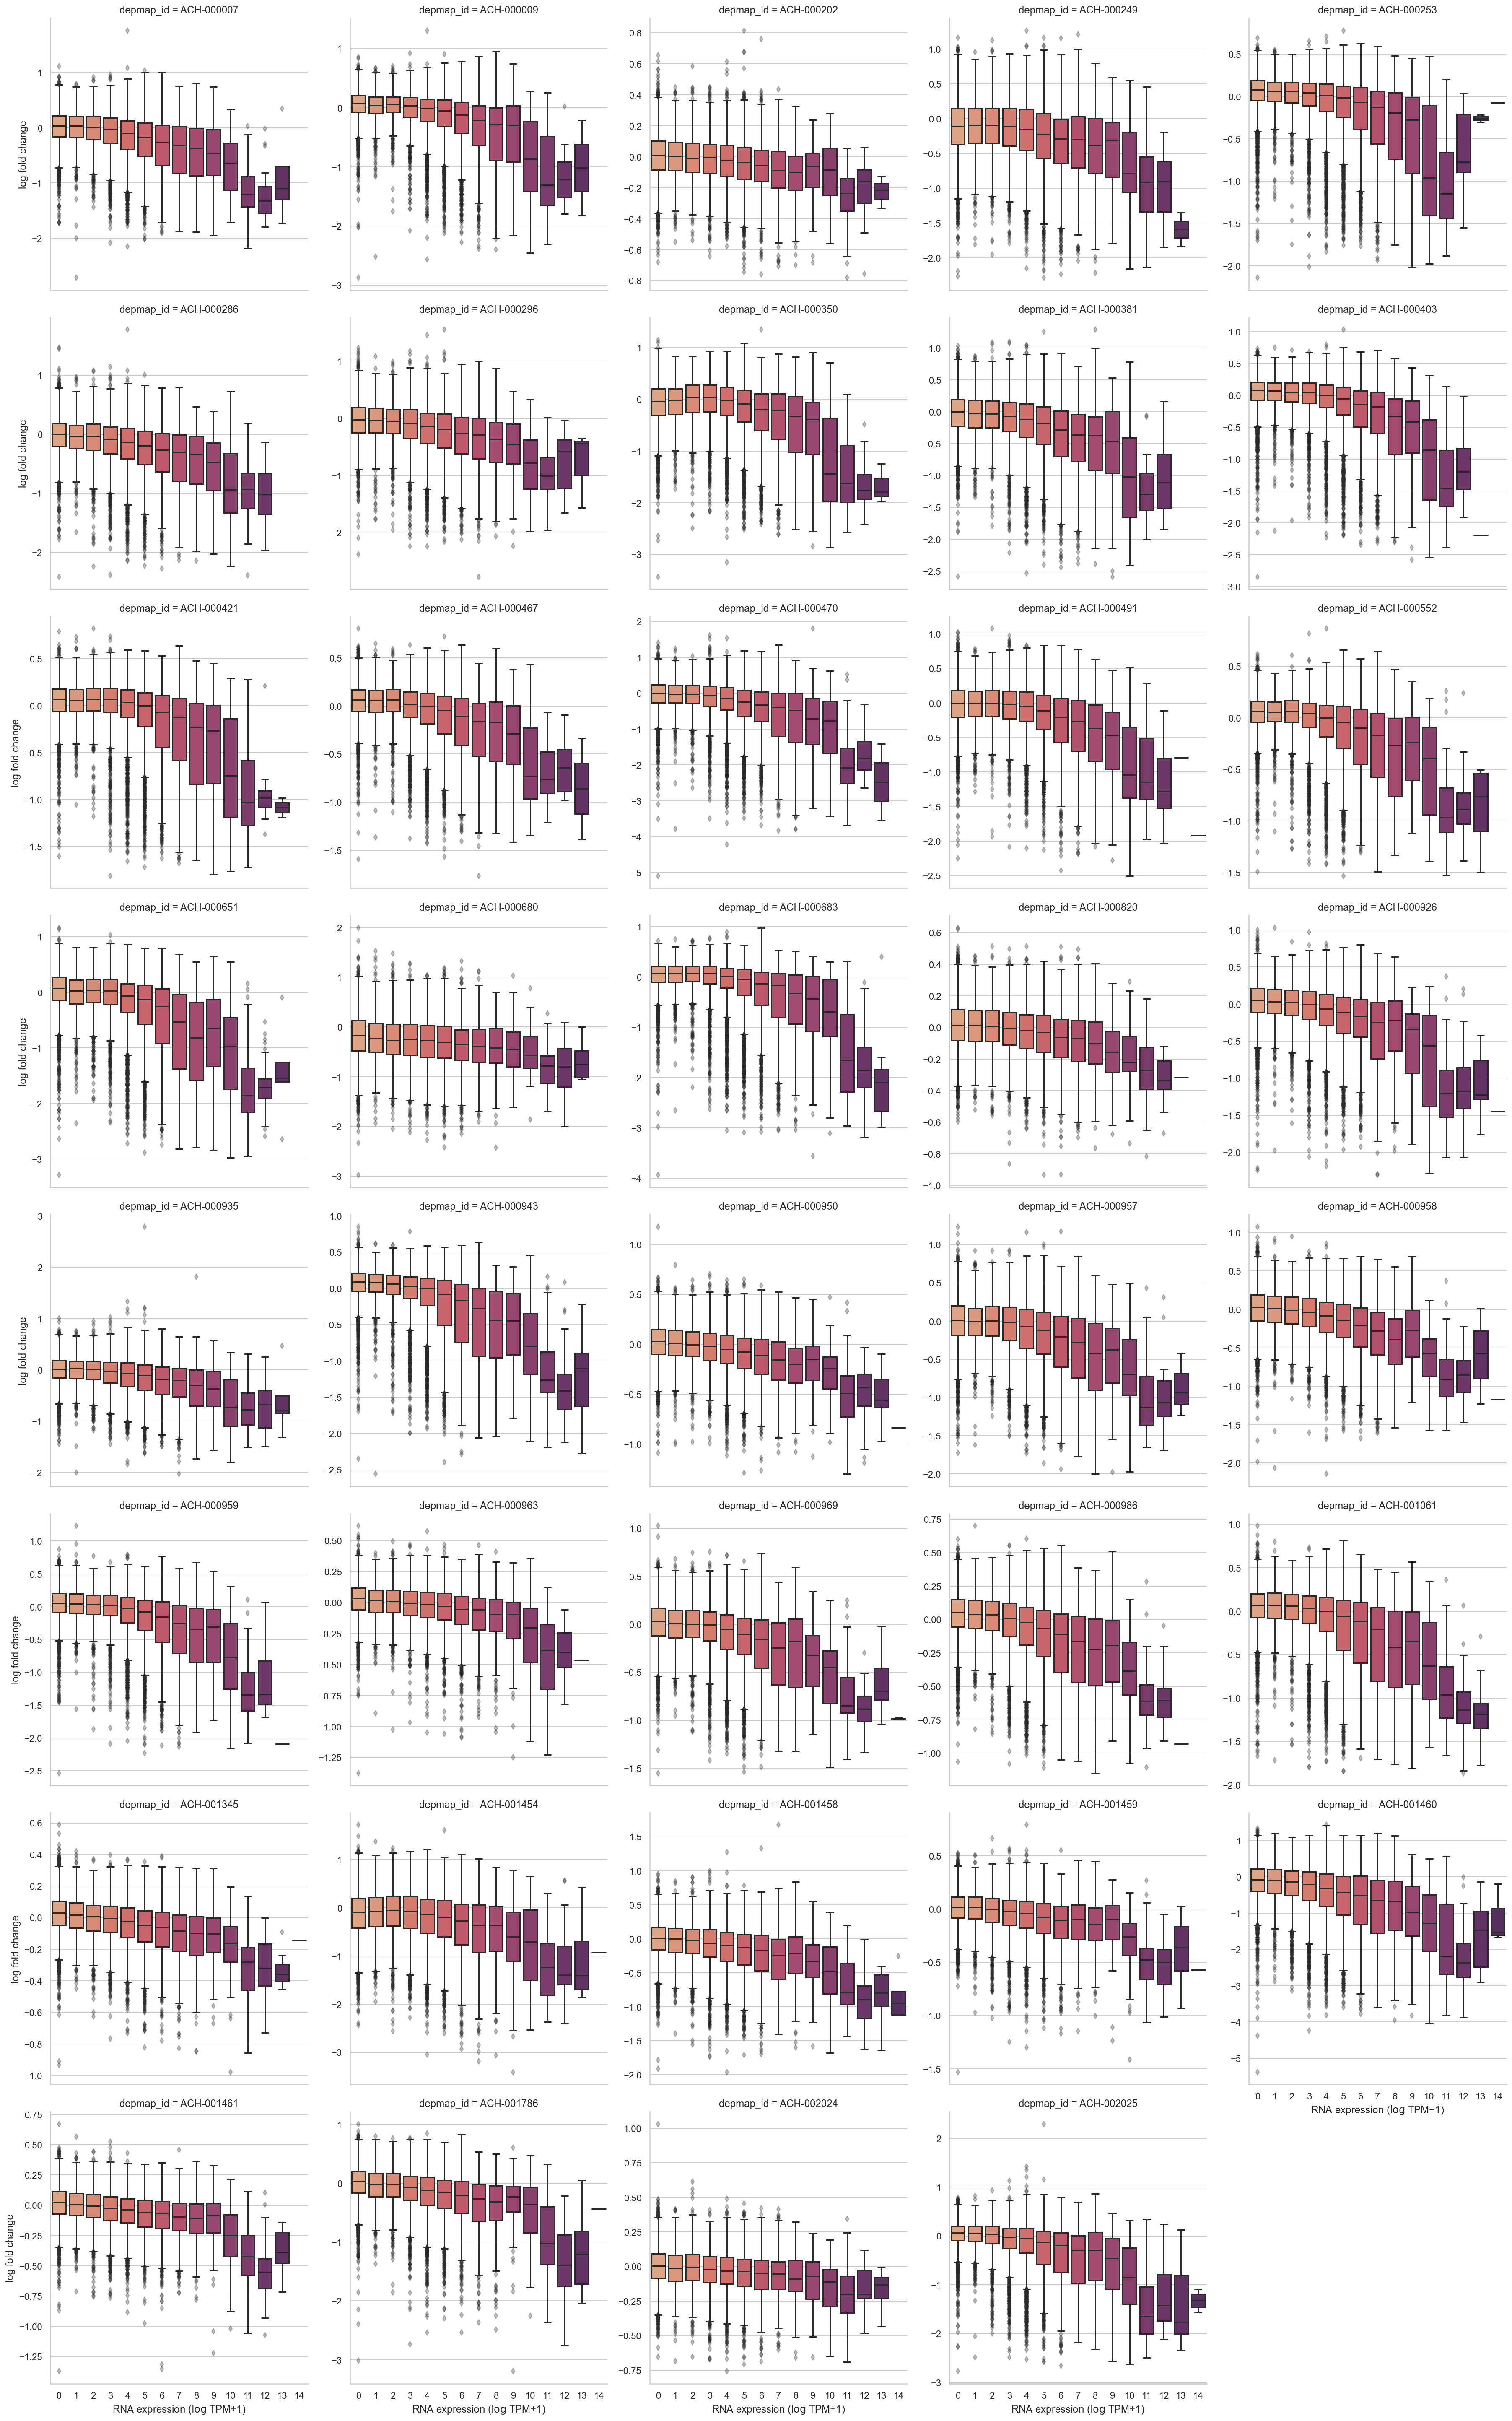

In [17]:
df = crc_data_avgs.assign(
    rna_expr_bin=lambda d: np.round(d.rna_expr).astype(int)
).assign(rna_expr_lbl=lambda d: d.rna_expr_bin.astype(str))

palette = sns.color_palette("flare", n_colors=len(df.rna_expr_bin.unique()))

fg = sns.catplot(
    data=df,
    x="rna_expr_bin",
    y="lfc",
    kind="box",
    palette=palette,
    col="depmap_id",
    col_wrap=5,
    sharey=False,
    flierprops={"alpha": 0.3},
)
fg.set_axis_labels(r"RNA expression ($\log$ TPM+1)", "log fold change")
plt.show()

#### Gene copy number

We can do the same with copy number.
Again, we see that there is frequently a negative correlation between this factor and LFC, but it is not as consistent as the trend with RNA expression.
Importantly, the trend has drastically different strengths in each cell line.

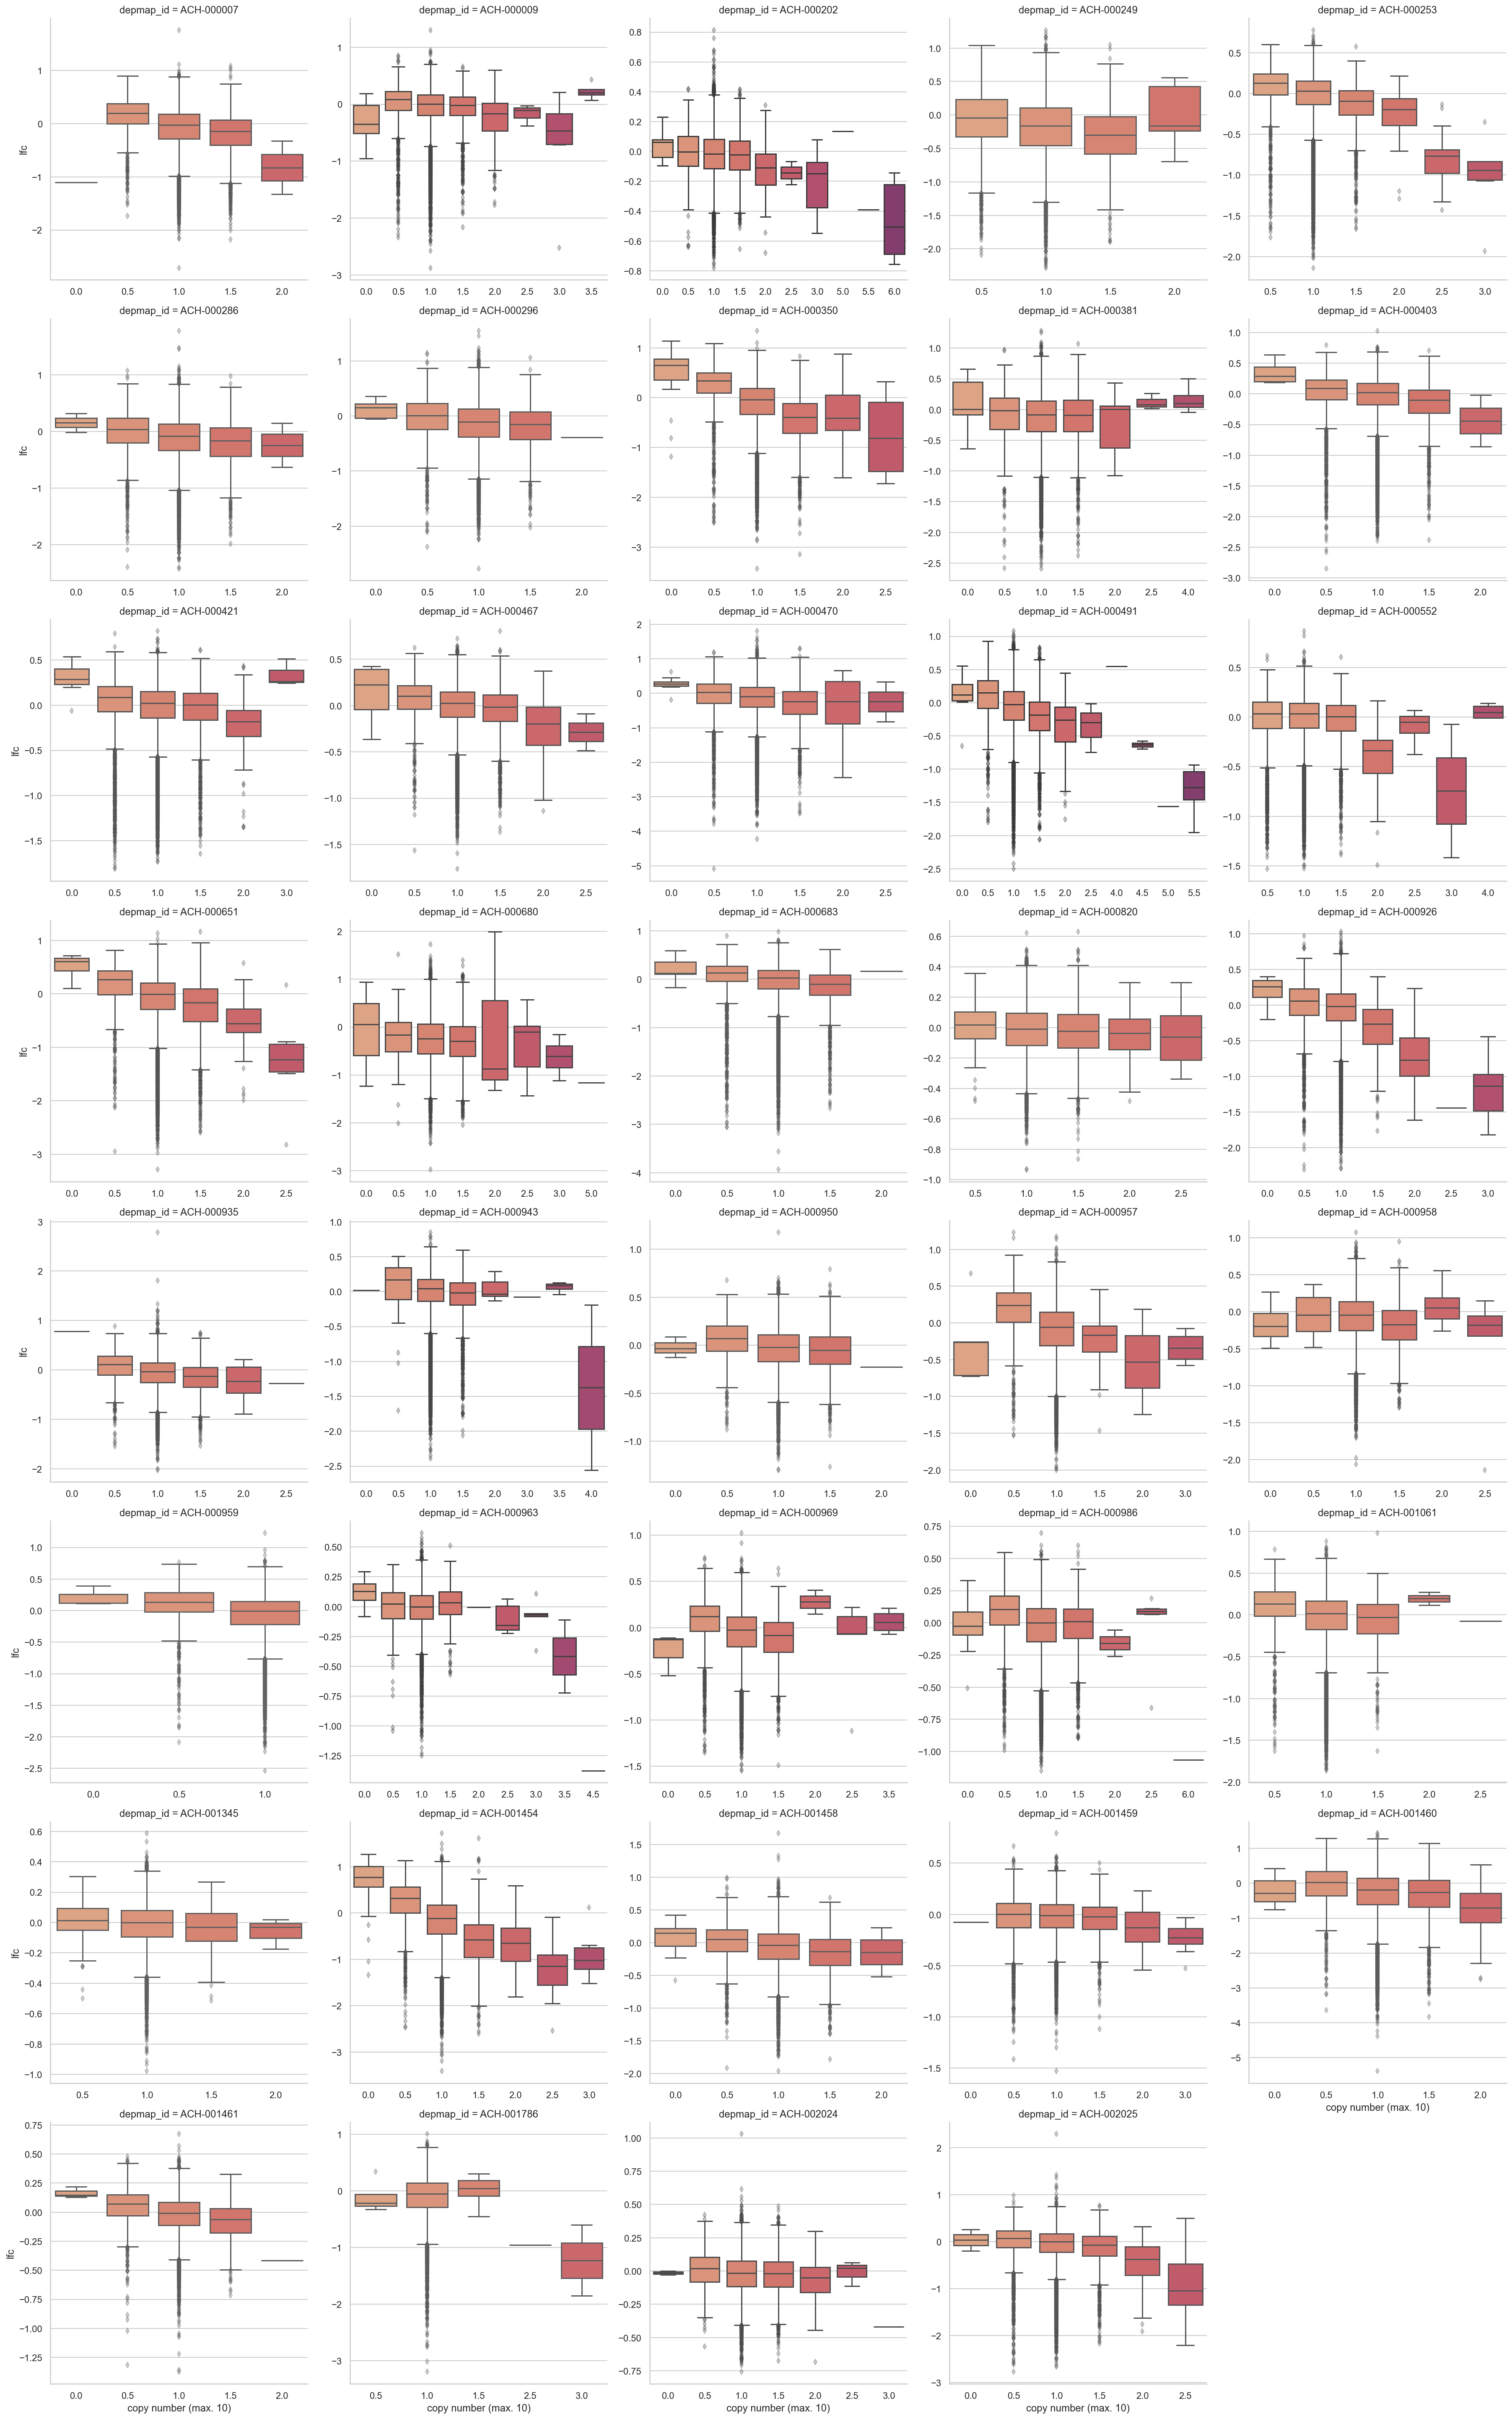

In [18]:
df = crc_data_avgs.assign(
    copy_number=lambda d: vhelp.squish_array(d.copy_number, lower=0, upper=10),
    copy_number_bin=lambda d: np.round(d.copy_number * 2).astype(int) / 2,
)

palette = sns.color_palette("flare", n_colors=len(df.copy_number_bin.unique()))

fg = sns.catplot(
    data=df,
    x="copy_number_bin",
    y="lfc",
    kind="box",
    palette=palette,
    col="depmap_id",
    col_wrap=5,
    sharex=False,
    sharey=False,
    flierprops={"alpha": 0.3},
)
fg.set_axis_labels("copy number (max. 10)")
plt.show()

#### Correlation with copy number for essential genes

In their publication introducing Chronos, the DepMap consortium demonstrated that the correlation between copy number and LFC was different for essential and nono-essential genes.
For essential genes, there was a positive correlation between CN and LFC, whereas it would be expected to be a negative correlation as shown above.
Their proposed explination is that because these genes are essential, true KO should lead to death.
Thus, what we are actually seeing are incomplete loss-of-function hits.

In [19]:
crc_data_avgs.head()

depmap_id hugo_symbol       lfc  rna_expr  copy_number
0  ACH-000007        A1BG  0.263330  0.137504     0.954248
1  ACH-000007        A1CF  0.067489  1.510962     0.964005
2  ACH-000007         A2M -0.328769  0.214125     0.963609
3  ACH-000007       A2ML1  0.060252  0.000000     0.963609
4  ACH-000007     A3GALT2 -0.152007  0.000000     0.971692

In [20]:
cn_lfc_corr = (
    crc_data_avgs.groupby("hugo_symbol")
    .corr()
    .reset_index()[["hugo_symbol", "level_1", "lfc"]]
    .query("level_1 != 'lfc'")
    .rename(columns={"level_1": "variable"})
)

In [21]:
gene_essentiality_df = pd.read_csv(
    data_io.data_path(data_io.DataFile.achilles_essentials)
)
essential_genes = gene_essentiality_df[gene_essentiality_df.is_essential].gene.tolist()
nonessential_genes = gene_essentiality_df[
    ~gene_essentiality_df.is_essential
].gene.tolist()
print(
    f"num. essential/non-essential genes: {len(essential_genes):,} / {len(nonessential_genes):,}"
)

num. essential/non-essential genes: 1,246 / 758


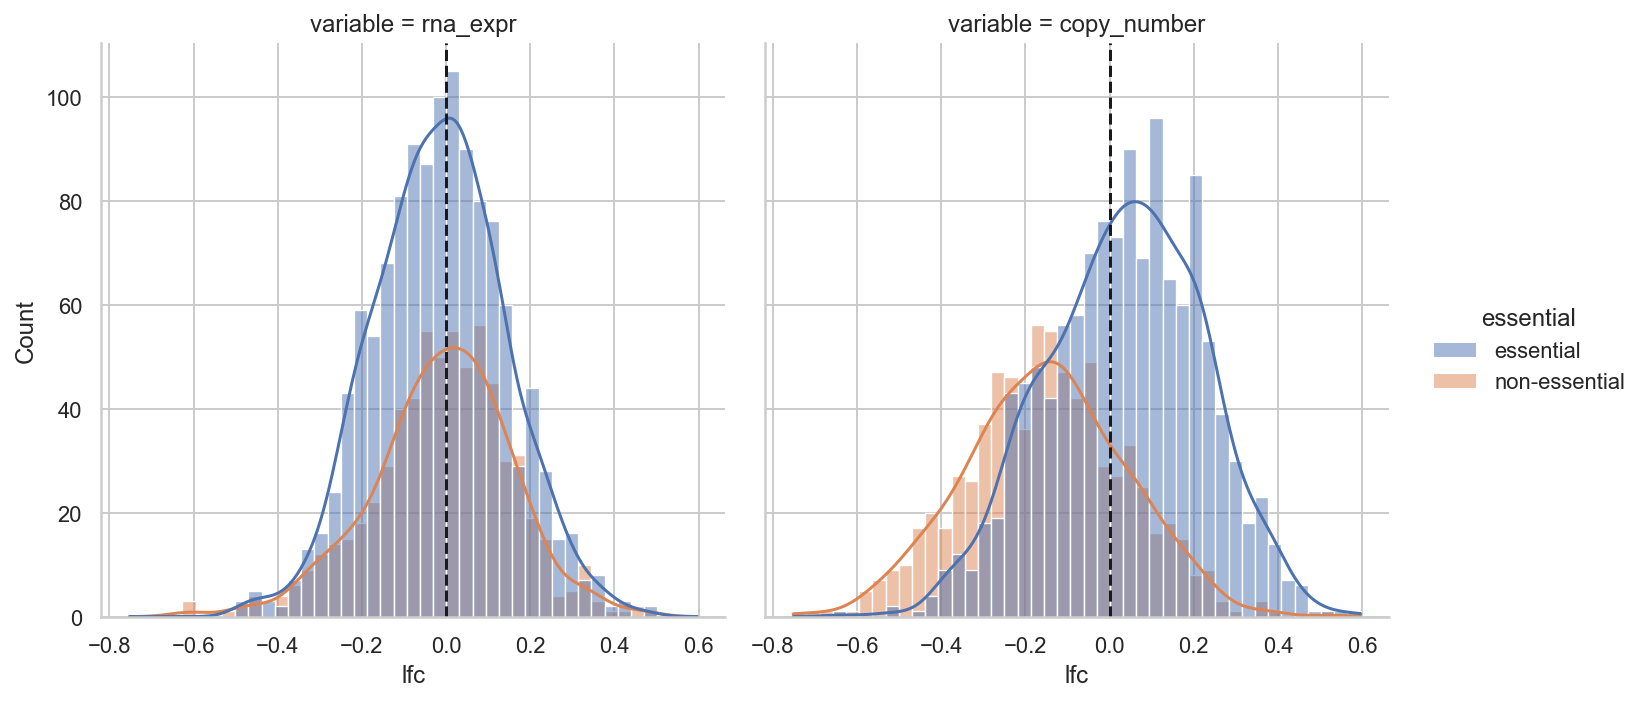

In [22]:
essential_comp_df = cn_lfc_corr[
    cn_lfc_corr.hugo_symbol.isin(essential_genes + nonessential_genes)
].assign(
    essential=lambda d: [
        "essential" if g in essential_genes else "non-essential" for g in d.hugo_symbol
    ]
)

fg = sns.displot(
    data=essential_comp_df, x="lfc", hue="essential", kde=True, col="variable"
)

for ax in fg.axes.flatten():
    ax.axvline(x=0, color="k", linestyle="--")

plt.show()

#### Mutations

I next looked at associations between mutation status and LFC.
We expect mutant oncogenes to have more negative LFC values than non-mutated oncogenes.
For example, cell lines with activating *KRAS* mutations should be more dependent upon *KRAS* that cell lines with WT *KRAS*.

In [23]:
mutation_counts = (
    crc_data[crc_data.screen == "broad"][
        [
            "hugo_symbol",
            "depmap_id",
            "is_mutated",
            "any_tcga_hotspot",
            "any_deleterious",
        ]
    ]
    .drop_duplicates()
    .fillna({"is_mutated": False, "any_tcga_hotspot": False, "any_deleterious": False})
    .groupby("hugo_symbol")[["is_mutated", "any_tcga_hotspot", "any_deleterious"]]
    .agg("mean")
    .compute()
    .reset_index(drop=False)
)

mutation_counts.head()

hugo_symbol  is_mutated  any_tcga_hotspot  any_deleterious
0        A1BG    0.128205               0.0         0.051282
1        A1CF    0.025641               0.0         0.000000
2         A2M    0.153846               0.0         0.051282
3       A2ML1    0.153846               0.0         0.051282
4     A3GALT2    0.128205               0.0         0.051282

In [24]:
mutation_counts.sort_values("is_mutated", ascending=False).head(10)

hugo_symbol  is_mutated  any_tcga_hotspot  any_deleterious
16571         TTN    0.871795          0.076923         0.358974
804           APC    0.846154          0.435897         0.743590
16203        TP53    0.666667          0.641026         0.256410
9550        MUC16    0.641026          0.025641         0.153846
15188       SYNE1    0.589744          0.025641         0.256410
17495       ZFHX3    0.538462          0.025641         0.179487
10429       OBSCN    0.538462          0.000000         0.153846
7954         KRAS    0.538462          0.512821         0.025641
34         ABCA13    0.512821          0.025641         0.205128
7931        KMT2C    0.512821          0.000000         0.102564

I first compared the LFC for the 20 most frequently mutated genes in the data set.
This includes many uninteresting genes including *TTN*, *NEB*, and some mucins.

In [25]:
top_mut_genes = (
    mutation_counts.sort_values("is_mutated", ascending=False)
    .head(20)
    .hugo_symbol.tolist()
)
top_mut_genes_data = crc_data[crc_data.hugo_symbol.isin(top_mut_genes)].compute()

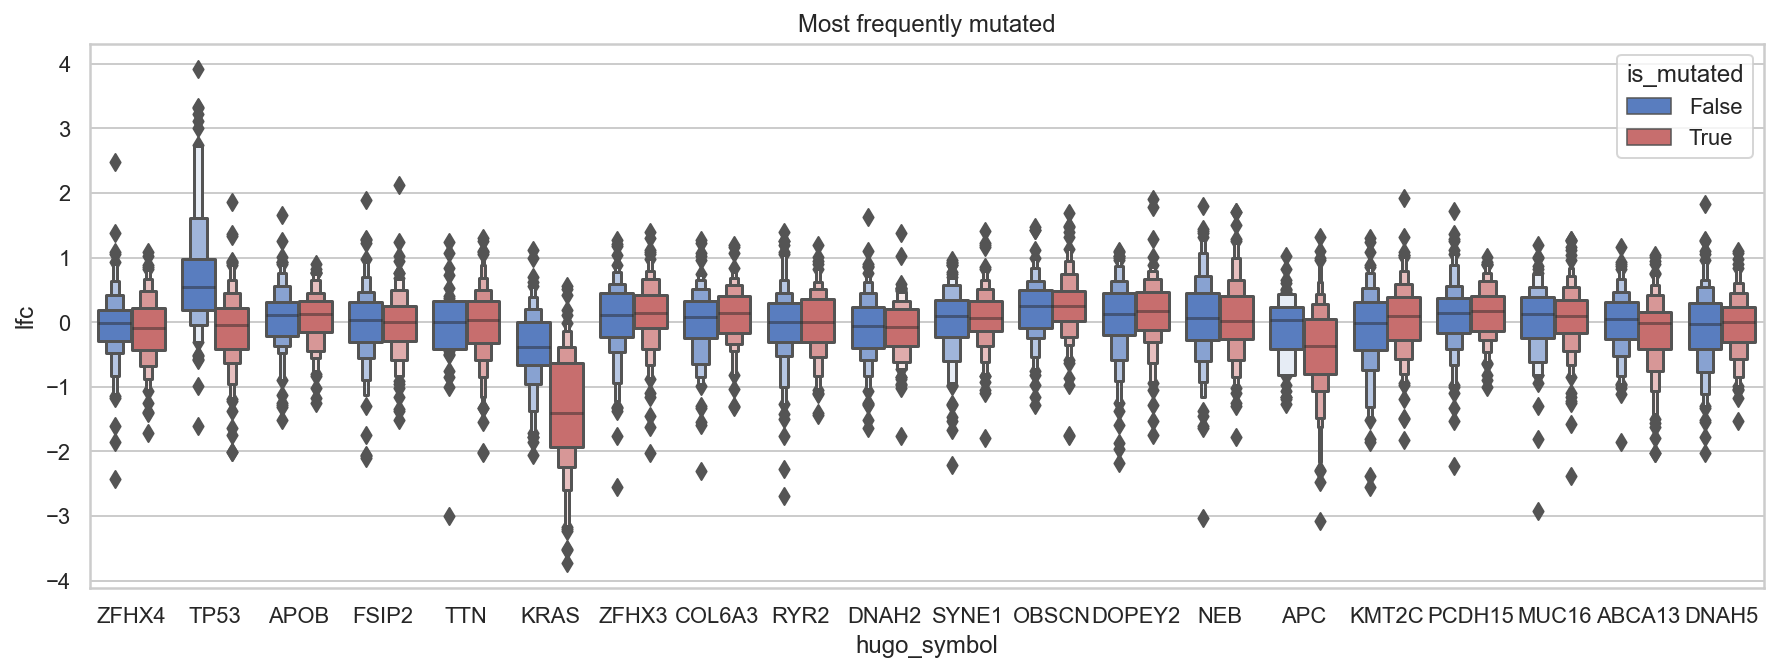

In [26]:
is_mutated_palette = {False: SeabornColor.BLUE, True: SeabornColor.RED}

fig = plt.figure(figsize=(15, 5))
sns.boxenplot(
    data=top_mut_genes_data,
    x="hugo_symbol",
    y="lfc",
    hue="is_mutated",
    palette=is_mutated_palette,
)
plt.title("Most frequently mutated")
plt.show()

I also plotted the results for genes listed as oncogenes in colorectal cancer by COSMIC's Cancer Gene Census (CGC).
Other than for *KRAS*, the different in LFC values is not as striking as I would expect.

In [27]:
cgc_genes = (
    pd.read_csv(data_io.data_path(data_io.DataFile.cgc))
    .dropna(subset=["tumor_types_somatic"])
    .filter_string("tumor_types_somatic", "color")
    .query("is_oncogene")
    .hugo_symbol.tolist()
)
cgc_genes_data = crc_data[crc_data.hugo_symbol.isin(cgc_genes)].compute()

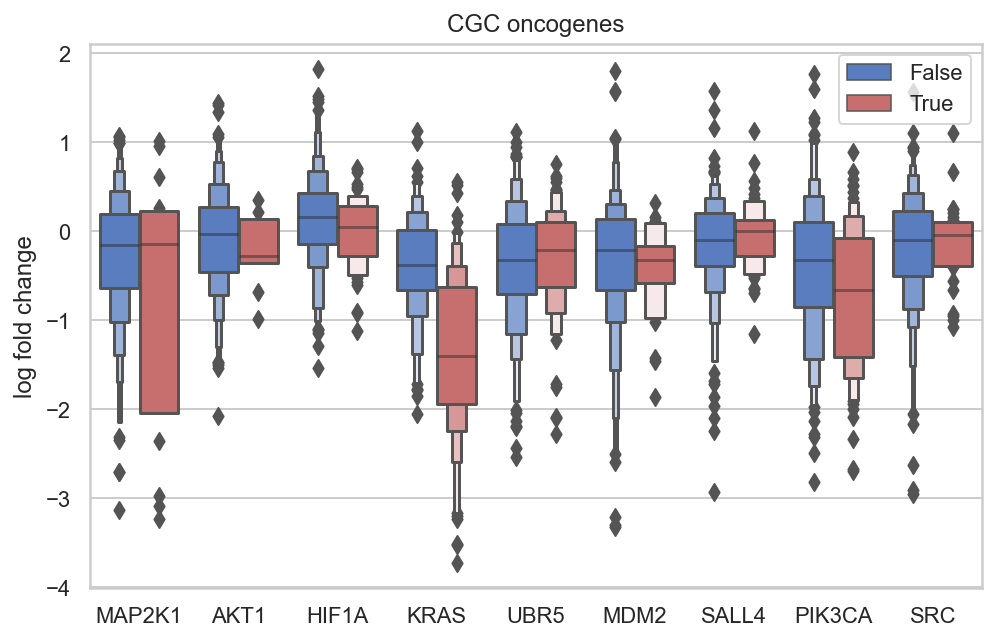

In [28]:
fig = plt.figure(figsize=(8, 5))
ax = sns.boxenplot(
    data=cgc_genes_data,
    x="hugo_symbol",
    y="lfc",
    hue="is_mutated",
    palette=is_mutated_palette,
)
plt.legend(loc="upper right")
ax.set_xlabel("")
ax.set_ylabel("log fold change")
plt.title("CGC oncogenes")
plt.show()

#### Batches

I next wanted to analyse the effects of different batches on the data.
There were mutliple sources of batch effects including the `replicate_id` and `p_dna_batch` identifiers.
However, each cell line was in a different `replicate_id`, so that source of variation can be ignored because it is inseparable from cell-line-to-cell-line variation.

In [29]:
crc_depmap_batches = (
    crc_data[crc_data.screen == "broad"][["depmap_id", "replicate_id", "p_dna_batch"]]
    .drop_duplicates()
    .compute()
    .reset_index(drop=True)
    .sort_values(["replicate_id", "p_dna_batch"])
)

I decided to look for clusters of cell lines by their batch, so I conducted PCA on the top 10% most variable genes.

In [30]:
lfc_matrix = (
    crc_data[crc_data.screen == "broad"][["depmap_id", "hugo_symbol", "lfc"]]
    .dropna()
    .groupby(["depmap_id", "hugo_symbol"])["lfc"]
    .mean()
    .reset_index(drop=False)
    .compute()
    .pivot_wider(index="hugo_symbol", names_from="depmap_id", values_from="lfc")
    .set_index("hugo_symbol")
)

In [31]:
def head_frac(df: pd.DataFrame, frac: float = 0.1) -> pd.DataFrame:
    if frac < 0.0 or frac > 1.0:
        raise ValueError(f"Value ({frac}) must be between 0 and 1.")
    return df.head(int(df.shape[0] * frac))


top_var_genes = (
    lfc_matrix.T.var()
    .reset_index(drop=False)
    .sort_values(0, ascending=False)
    .pipe(head_frac)
    .hugo_symbol.tolist()
)

len(top_var_genes)

1811

In [32]:
pca = PCA(n_components=10)
pca_lfc_matrix = pca.fit_transform(lfc_matrix.loc[top_var_genes].values.T)

Principal component 1 accounts for most of the variation.

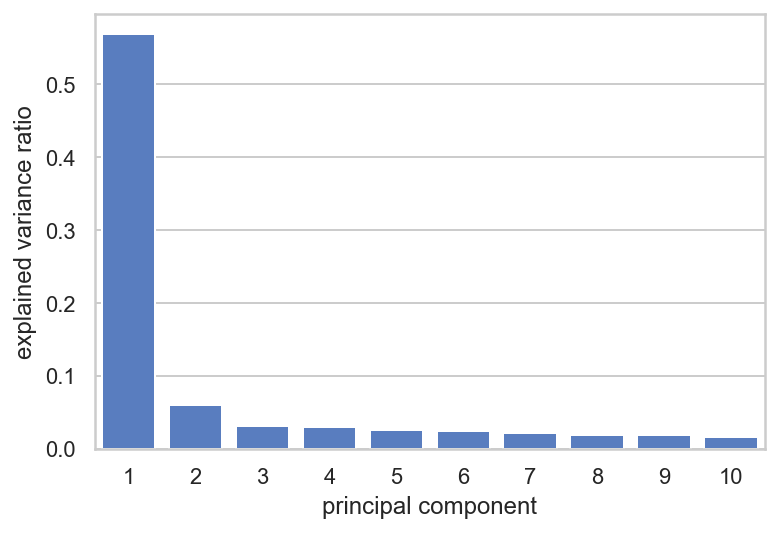

In [33]:
ax = sns.barplot(
    x=list(range(1, 11)), y=pca.explained_variance_ratio_, color=SeabornColor.BLUE
)
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")
plt.show()

In [34]:
cellline_info = (
    crc_data[crc_data.screen == "broad"][
        [
            "depmap_id",
            "replicate_id",
            "p_dna_batch",
            "primary_or_metastasis",
            "is_male",
            "age",
        ]
    ]
    .drop_duplicates()
    .assign(p_dna_batch=lambda d: d.p_dna_batch.astype(str).astype("category"))
    .compute()
)

In [35]:
pca_transform_df = (
    pd.DataFrame(pca_lfc_matrix, columns=[f"PC{i+1}" for i in range(10)])
    .assign(depmap_id=lfc_matrix.columns)
    .merge(cellline_info, on="depmap_id")
)

The following plots look for assoications between known factors of the cell lines (batch, sex, age, and primary vs. metastasis) and the first two PCs, but no strong associations were found.

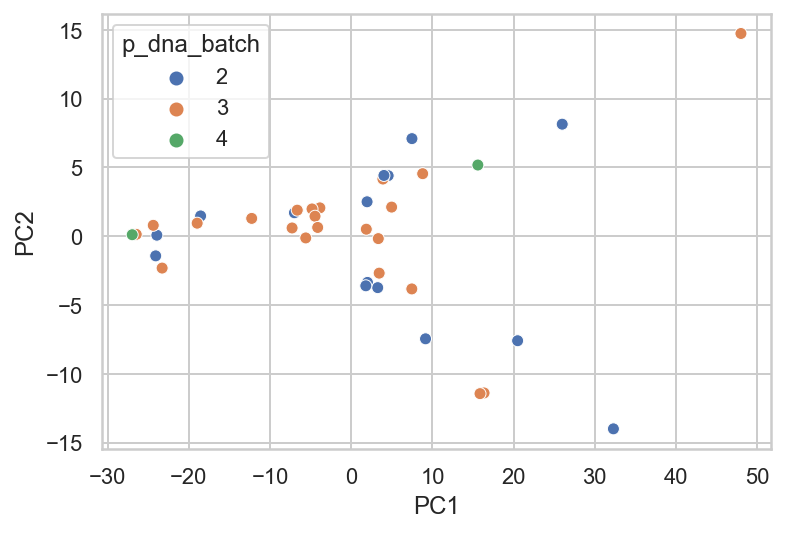

In [36]:
sns.scatterplot(data=pca_transform_df, x="PC1", y="PC2", hue="p_dna_batch");

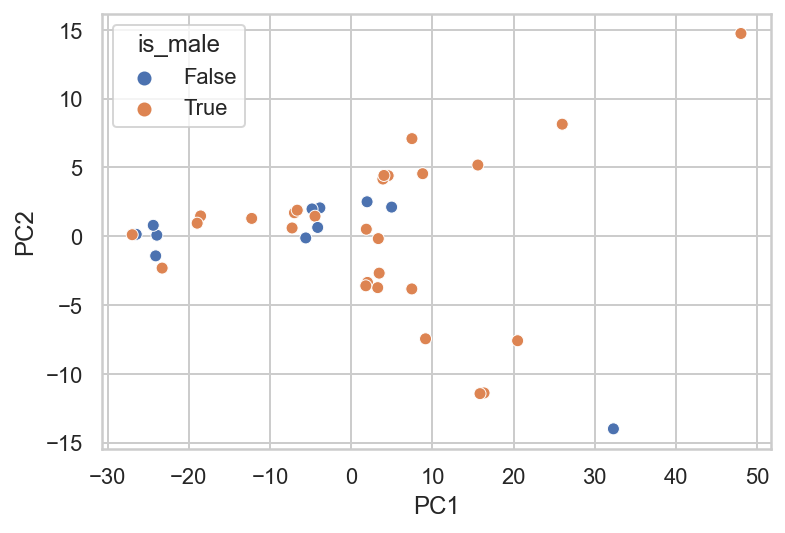

In [37]:
sns.scatterplot(data=pca_transform_df, x="PC1", y="PC2", hue="is_male");

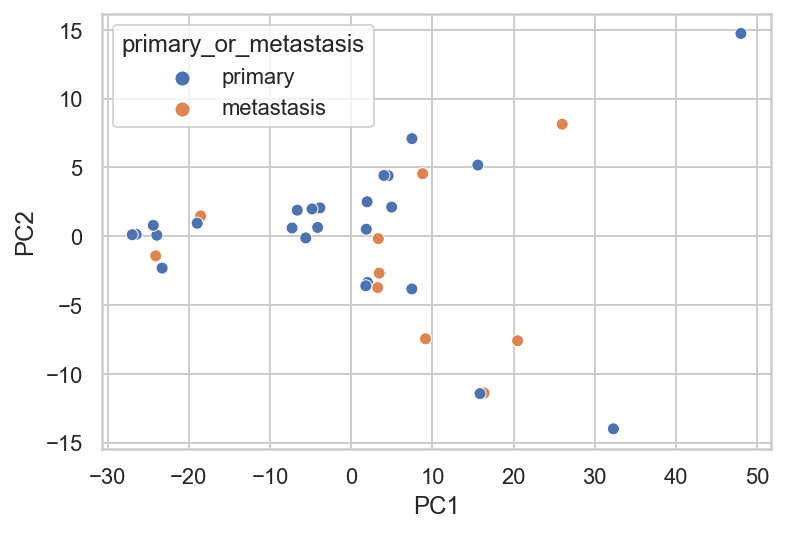

In [38]:
sns.scatterplot(data=pca_transform_df, x="PC1", y="PC2", hue="primary_or_metastasis");

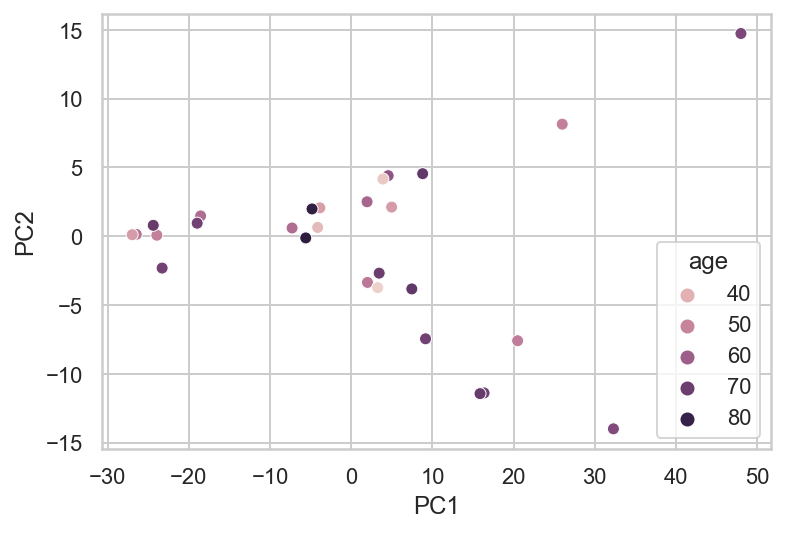

In [39]:
sns.scatterplot(data=pca_transform_df, x="PC1", y="PC2", hue="age");

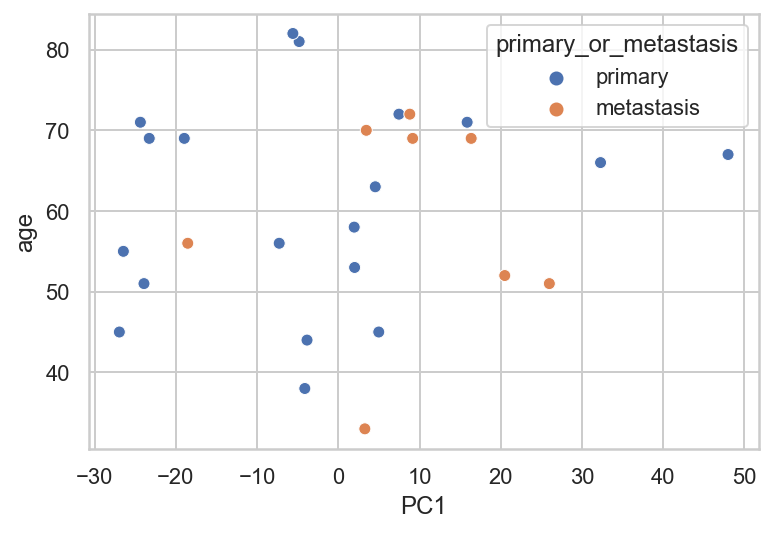

In [40]:
sns.scatterplot(data=pca_transform_df, x="PC1", y="age", hue="primary_or_metastasis");

#### Multiple hits on the target gene

Guides that target multiple genes have already been removed from the data set.
However, one interesting note is that some sgRNA target the same gene in muiltiple locations.
I was curious if there was a systematic difference between guides that hit a gene once versus those that hit mutliple locations.

Overall, over 90% of the guides appear to hit their target gene in mutliple locations.

In [41]:
(crc_data[crc_data.screen == "broad"][["multiple_hits_on_gene"]].mean().compute())

multiple_hits_on_gene    0.923131
dtype: float64

I extracted only the data where there exist guides that have a single target locus and guides that have multiple target locii for a given gene in a given cell line.

In [42]:
mulitple_hit_groups = (
    crc_data[crc_data.screen == "broad"][
        ["multiple_hits_on_gene", "hugo_symbol", "depmap_id"]
    ]
    .groupby(["hugo_symbol", "depmap_id"])["multiple_hits_on_gene"]
    .mean()
    .reset_index(drop=False)
    .query("multiple_hits_on_gene < 1.0")
    .query("multiple_hits_on_gene > 0.0")
    .compute()
    .reset_index(drop=True)
)

mulitple_hit_groups.head()

hugo_symbol   depmap_id  multiple_hits_on_gene
0      AHNAK2  ACH-000249                   0.25
1        AMBN  ACH-000249                   0.25
2    ANKRD30A  ACH-000249                   0.50
3    ANKRD36B  ACH-000249                   0.50
4     C9orf57  ACH-000249                   0.25

In [43]:
def zscore(df: pd.DataFrame) -> pd.DataFrame:
    df["lfc_z"] = stats.zscore(df.lfc.values)
    return df


multiple_hits_data = (
    crc_data[crc_data.screen == "broad"][
        ["multiple_hits_on_gene", "hugo_symbol", "depmap_id", "lfc", "sgrna"]
    ]
    .merge(mulitple_hit_groups[["depmap_id", "hugo_symbol"]])
    .compute()
    .groupby(["hugo_symbol", "depmap_id"])
    .apply(zscore)
    .reset_index()
)

multiple_hits_data.head()

index  multiple_hits_on_gene hugo_symbol   depmap_id       lfc  \
0      0                   True    ANKRD30A  ACH-000249 -0.303036   
1      0                   True    ANKRD30A  ACH-000680 -1.304264   
2      0                  False      ZNF880  ACH-000820  0.136020   
3      1                   True    ANKRD30A  ACH-000249 -0.351390   
4      1                   True    ANKRD30A  ACH-000680 -0.234602   

                  sgrna     lfc_z  
0  AACATCTGAGAAATTTACGT -0.926411  
1  AACATCTGAGAAATTTACGT -1.277391  
2  GACATTTCCACTCCTCCTGA -1.159560  
3  AAGACCTAGGAAGATCGCAT -1.006461  
4  AAGACCTAGGAAGATCGCAT  0.397502

The following plots shows the LFC values in each cell line separating between guides with multiple hits and those with only one.
By eye, there does seem to be a slight decrease on average in LFC for guides that hit the gene multiple times.

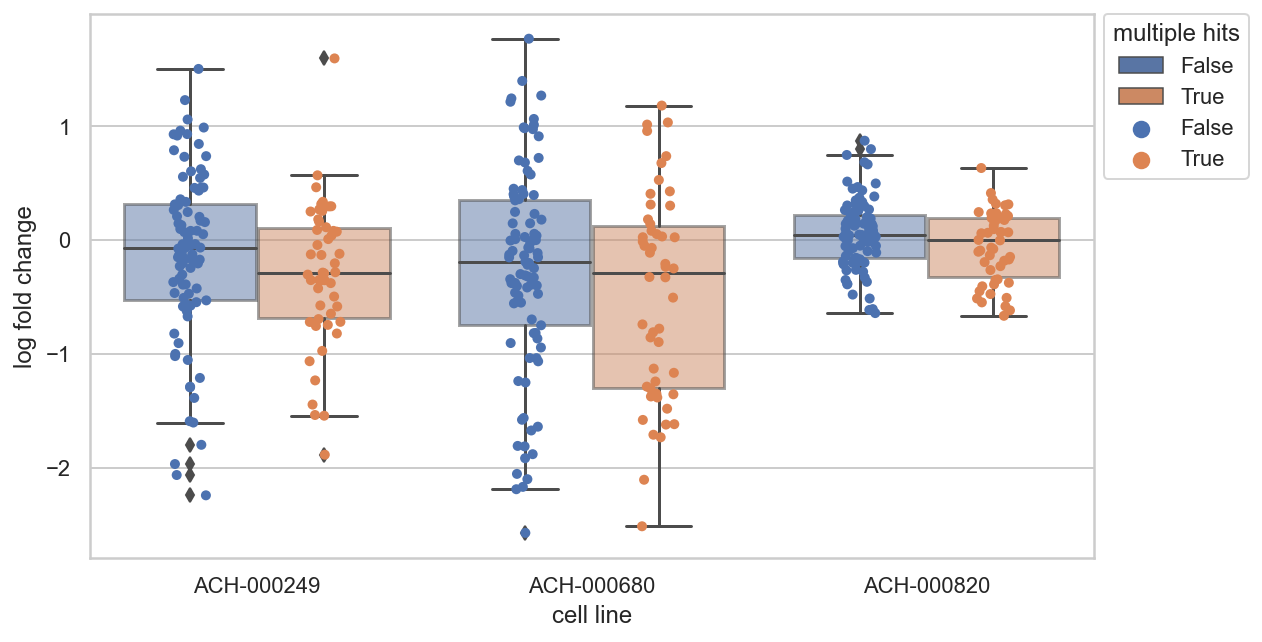

In [44]:
fig = plt.figure(figsize=(9, 5))
ax = sns.boxplot(
    data=multiple_hits_data,
    x="depmap_id",
    y="lfc",
    hue="multiple_hits_on_gene",
    boxprops={"alpha": 0.5},
)
sns.stripplot(
    data=multiple_hits_data,
    x="depmap_id",
    y="lfc",
    hue="multiple_hits_on_gene",
    dodge=True,
    ax=ax,
)

ax.set_xlabel("cell line")
ax.set_ylabel("log fold change")
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, title="multiple hits")
plt.show()

However, if the data is standardized by gene and cell line, the effect is not as visible.

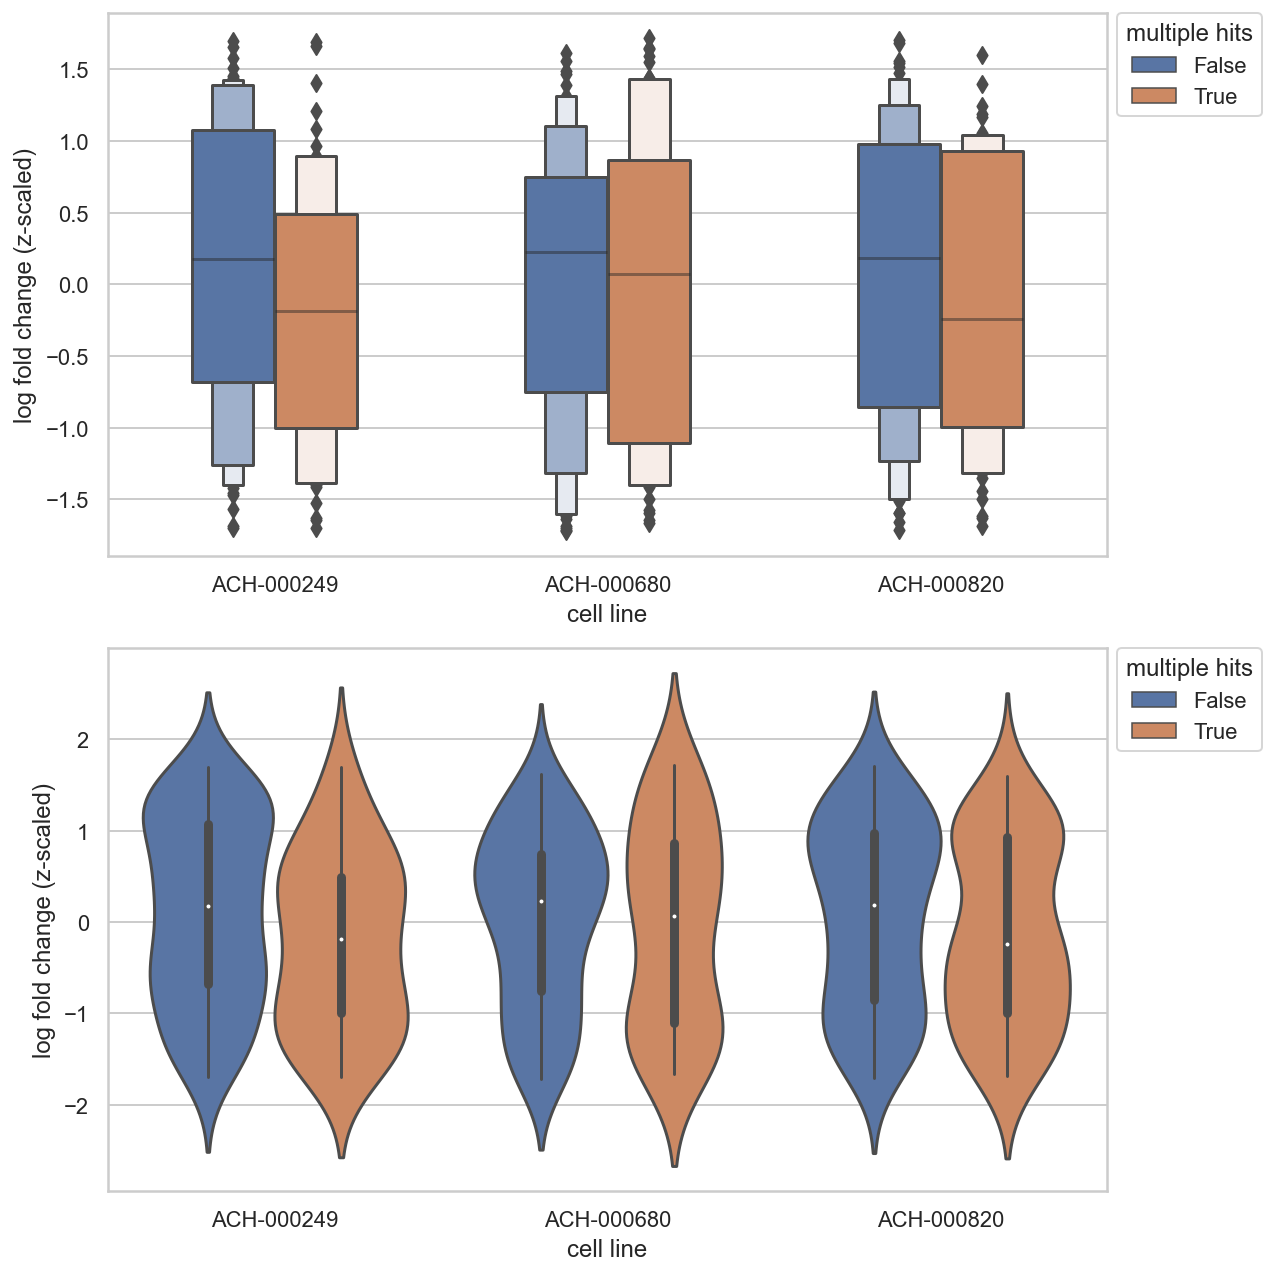

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))

sns.boxenplot(
    data=multiple_hits_data,
    x="depmap_id",
    hue="multiple_hits_on_gene",
    y="lfc_z",
    width=0.5,
    ax=axes[0],
)
sns.violinplot(
    data=multiple_hits_data,
    x="depmap_id",
    hue="multiple_hits_on_gene",
    y="lfc_z",
    ax=axes[1],
)

for ax in axes:
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0, title="multiple hits")
    ax.set_xlabel("cell line")
    ax.set_ylabel("log fold change (z-scaled)")

fig.tight_layout()
plt.show()

#### Visualizing copy number along chromosomes

The last analysis I conducted was just to visualize the copy number data along the chromosomes.
This diesn't provide any interesting insight, I just want to see what it looks like.

In [46]:
CELL_LINE = "ACH-000680"
cell_chromosome_df = crc_data[crc_data.screen == "broad"].query(
    f"depmap_id == '{CELL_LINE}'"
)[
    [
        "hugo_symbol",
        "sgrna",
        "depmap_id",
        "lfc",
        "copy_number",
        "rna_expr",
        "sgrna_target_chr",
        "genome_alignment",
    ]
]

In [47]:
cell_cn_df = (
    cell_chromosome_df[["copy_number", "sgrna_target_chr", "genome_alignment", "lfc"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .compute()
    .pipe(biohelp.extract_chromosome_location_to_df, col_name="genome_alignment")
    .pipe(biohelp.make_chromosome_categorical, chr_col="chr")
)

cell_cn_df.head()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/numpy/core/numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


copy_number sgrna_target_chr  genome_alignment       lfc chr        pos  \
0     1.456644                2  chr2_130522105_- -0.067602   2  130522105   
1     1.132130               11  chr11_89916950_-  0.531739  11   89916950   
2     0.763323                5   chr5_71055421_- -0.903544   5   71055421   
3     0.763323                5   chr5_69572480_+ -0.758697   5   69572480   
4     0.987681                X  chrX_155898173_+  0.327171   X  155898173   

   strand  
0      -1  
1      -1  
2      -1  
3       1  
4       1

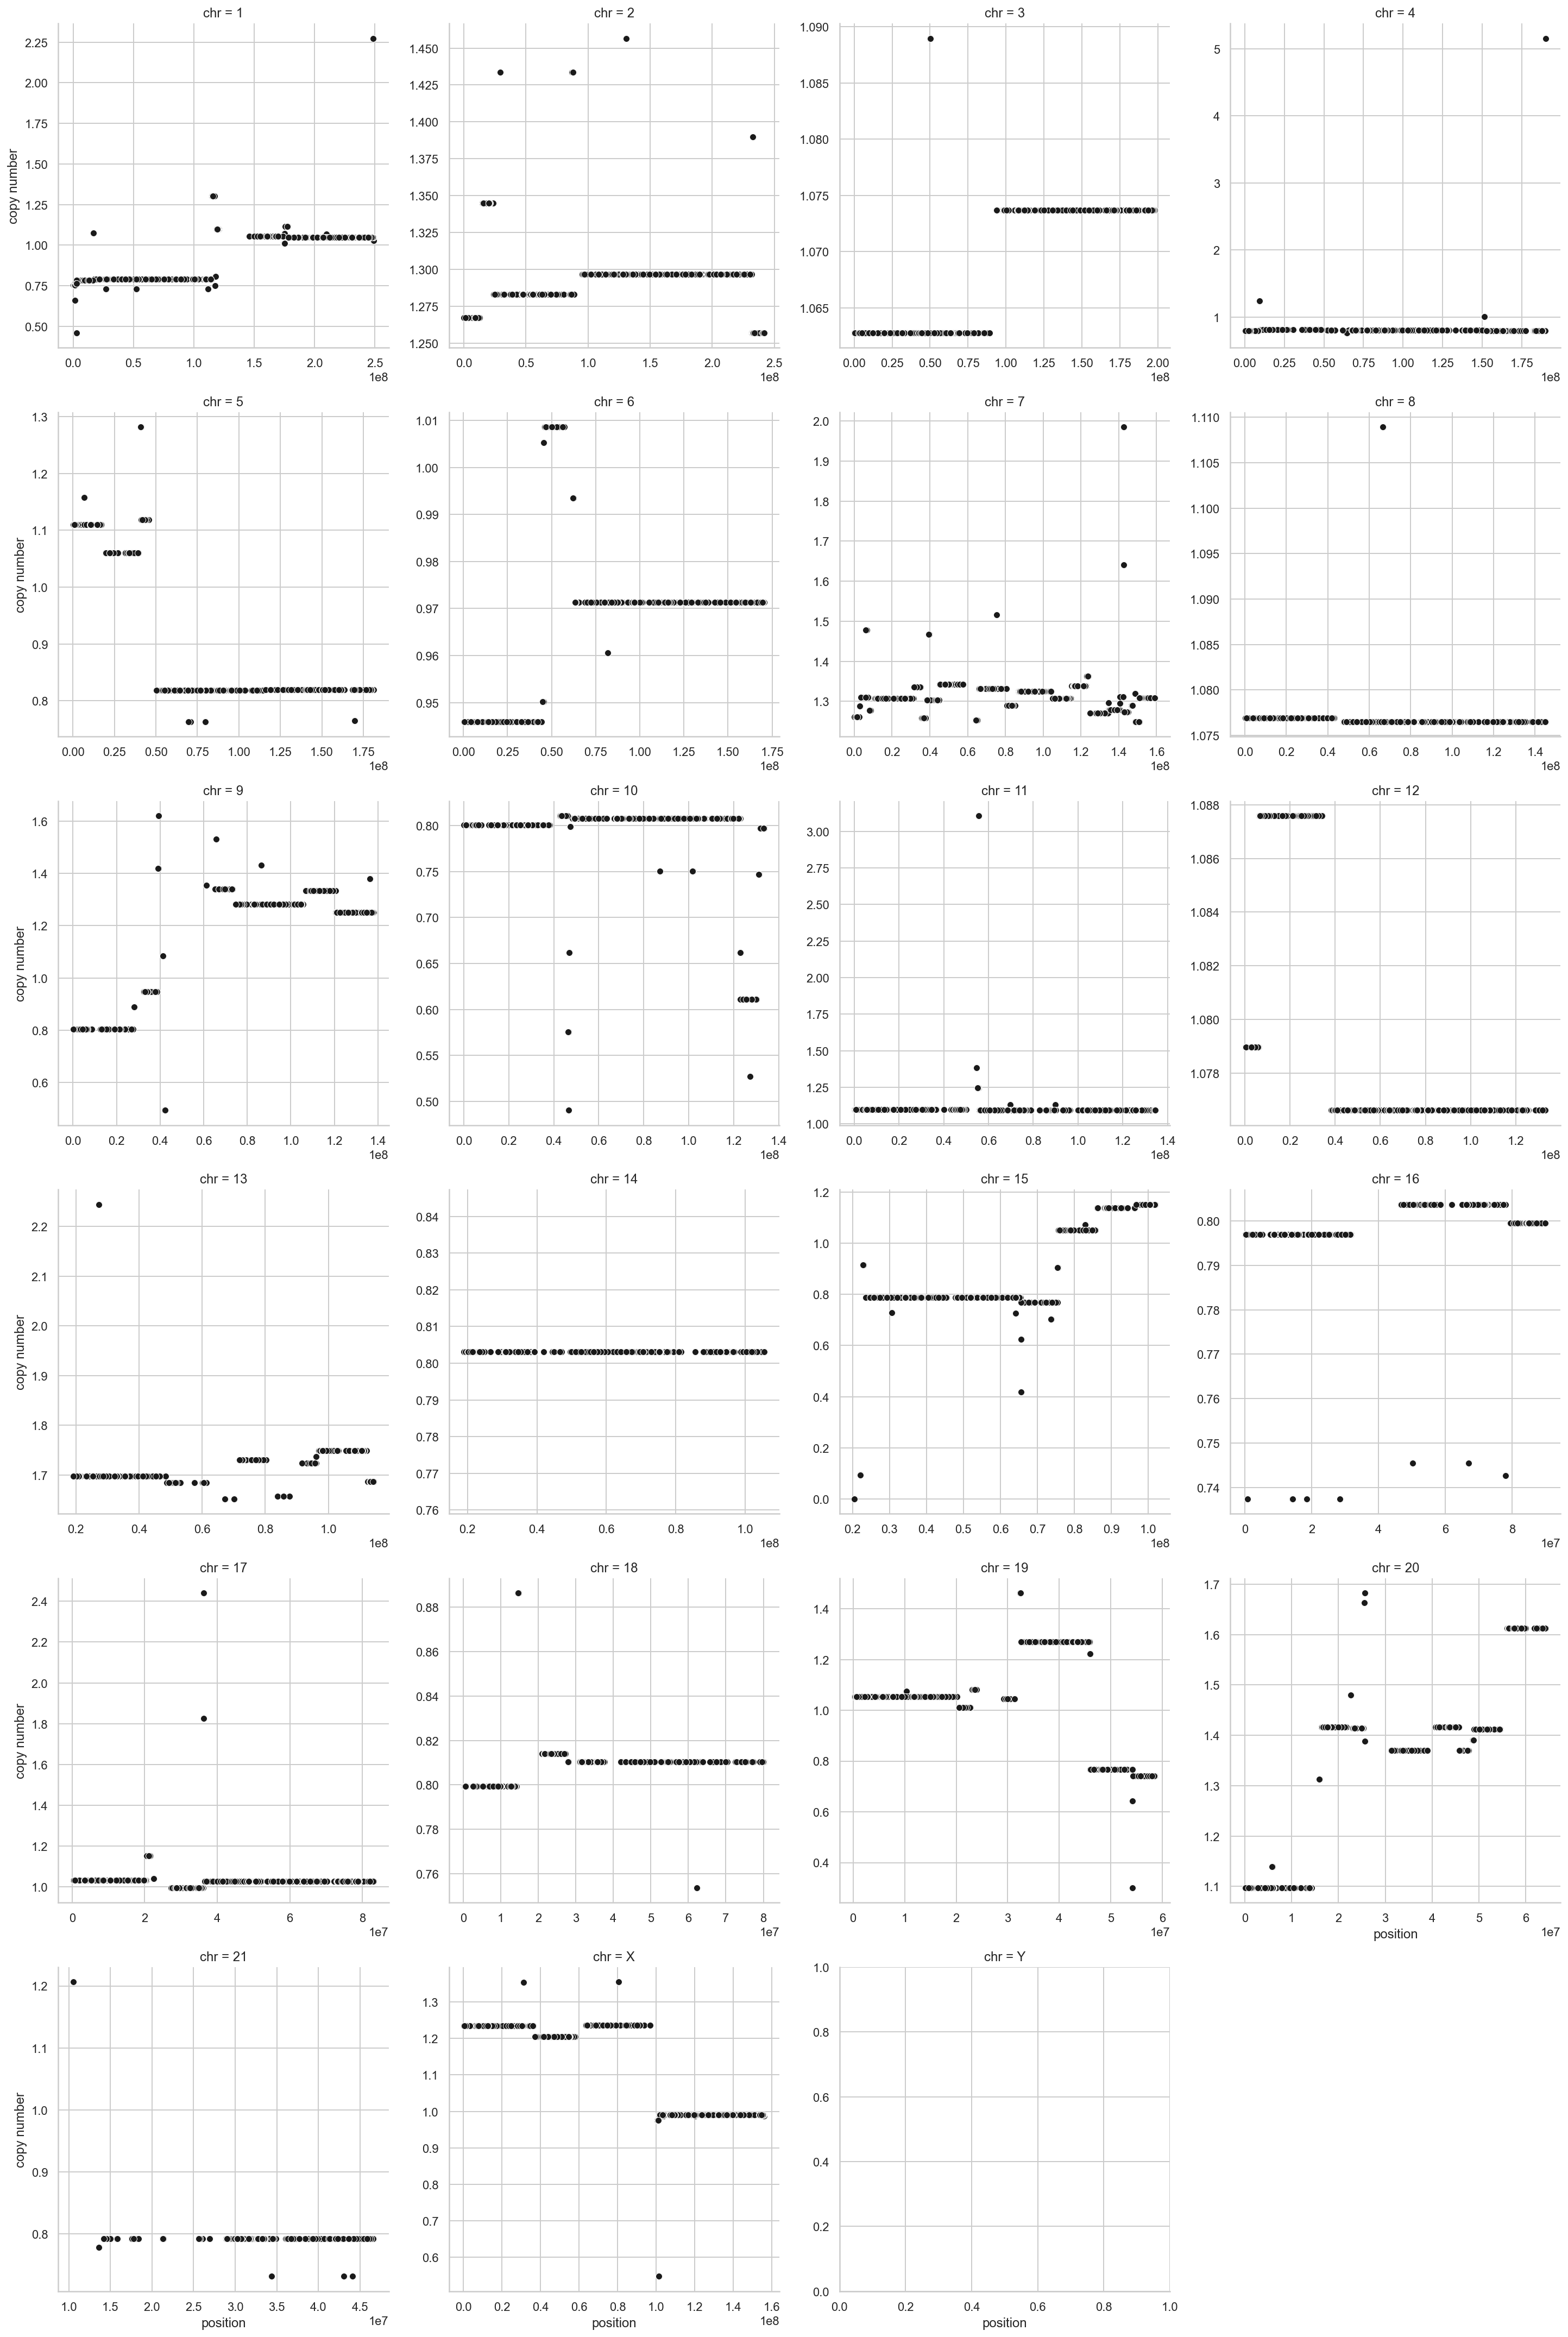

In [48]:
fg = sns.relplot(
    data=cell_cn_df,
    x="pos",
    y="copy_number",
    color="k",
    col="chr",
    col_wrap=4,
    kind="scatter",
    facet_kws={"sharex": False, "sharey": False},
)
fg.set_axis_labels("position", "copy number")
plt.show()

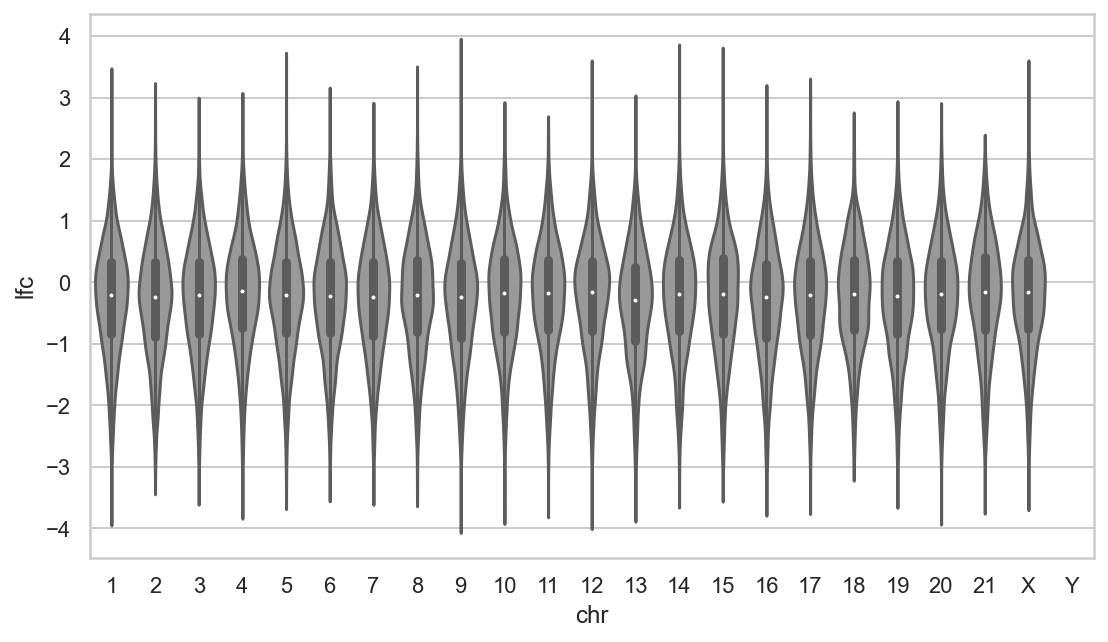

In [49]:
fig = plt.figure(figsize=(9, 5))
sns.violinplot(data=cell_cn_df, x="chr", y="lfc", color="0.6");

---

In [50]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 7.26 minutes


In [51]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-21

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: sp7-parameterizations

arviz     : 0.11.2
re        : 2.2.1
numpy     : 1.20.1
matplotlib: 3.3.4
pymc3     : 3.11.1
dask      : 2021.7.0
theano    : 1.0.5
plotnine  : 0.8.0
pandas    : 1.2.3
seaborn   : 0.11.1
janitor   : 0.20.14
scipy     : 1.6.0

